In [82]:
# UNCOMMENT FOR INTERACTIVE PLOTTING
# %matplotlib notebook
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, rc, cm
import time
from snakelib import FastSnake, show_gui, NeuralAgent
import snakelib as snklib
rc("animation", html="html5")


(ML:practical_work:genetic_snake)=
# Reinforcement learning on snake with a genetic neural network

:::{admonition} Required files
:class: important
In order to work properly, this notebook requires the following modules in its folder:

* {download}`snakelib.py <snakelib.py>`

Put it in your working directory along with this notebook. 

:::


This notebook is an example of supervised learning applied to video games. You will use the legendary game Snake rewritten in Python for the occasion and will try to develop an automatic game strategy. In a first step, by hand and in a second step using a genetic algorithm to evolve a neural network. Graphical examples will allow to see the evolution of the game performances.

## Part 1: Try the game
![](https://www.pricepony.com.ph/blog/wp-content/uploads/2015/11/bestgameever-nokia-meme-628-300x300.jpg)

In this first part, you are asked to try the game and check that you understand the rules. Try to imagine what you need to know to win a game.

Box(children=(Button(button_style='success', description='snake.turn(+1)', icon='arrow-left', style=ButtonStyl…

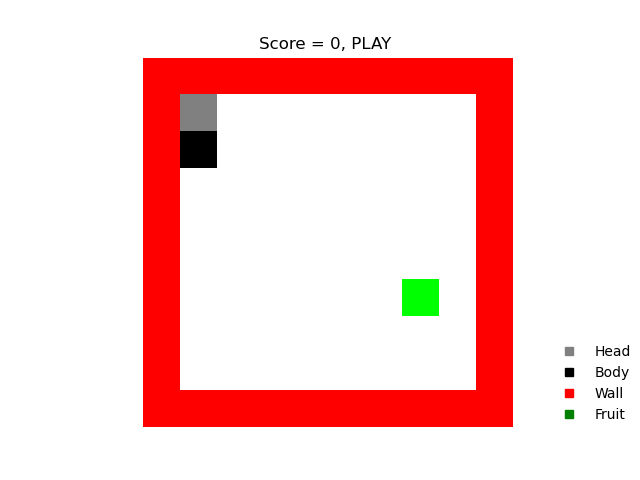

In [93]:
np.random.seed(0) # Fixing the seed
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
snake = FastSnake(Nrow=10, Ncol=10)
show_gui(snake, ax)

In [94]:
plt.close()

### Some explications

#### Game Grid
The game grid is composed of a number of columns noted Ncol and a number of lines noted Nrow.


In [95]:
print(f"Grid dimensions: {snake.Ncol} columns, {snake.Nrow} rows, a total of {snake.Ncell} elements")

Grid dimensions: 10 columns, 10 rows, a total of 100 elements


Each element of the grid is identified by an unique index.

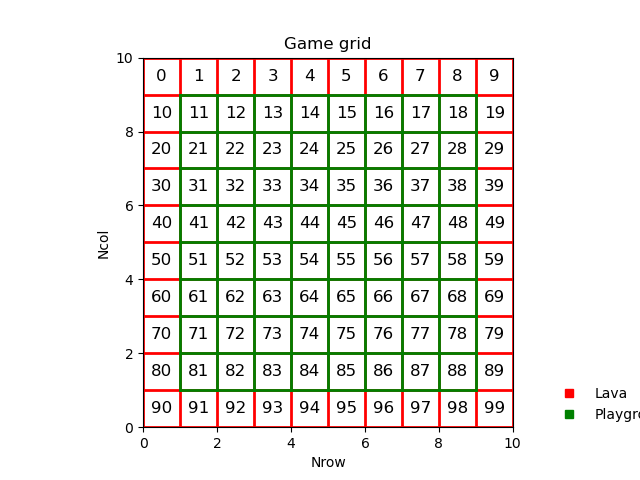

In [96]:
plt.figure()
grid_img = np.ones_like(snake.all_positions.reshape(snake.Nrow,snake.Ncol))
plt.imshow(grid_img,
           cmap="binary", origin="upper", extent=[0, snake.Nrow, 0, snake.Ncol])
for l in range(snake.Nrow):
    for c in range(snake.Ncol):
        z = snake.all_positions.reshape(snake.Nrow,snake.Ncol)[l, c]
        xc = snake.Nrow-1 - l
        yc = c        
        plt.text(yc + 0.5, xc + 0.5, str(z), va="center", ha="center", fontsize=12)
        
for g in range(snake.Nrow+1):
    plt.plot(np.linspace(0, snake.Nrow, num=snake.Nrow+1), np.ones(snake.Nrow + 1) * g, "r-", linewidth=2)
    plt.plot(np.ones(snake.Nrow + 1) * g, np.linspace(0, snake.Nrow, num=snake.Nrow+1), "r-", linewidth=2)
    
for g in range(1, snake.Nrow):
    plt.plot(np.linspace(1, snake.Nrow-1, num=snake.Nrow), np.ones(snake.Nrow) * g, "g-", linewidth=2)
    plt.plot(np.ones(snake.Nrow) * g, np.linspace(1, snake.Nrow-1, num=snake.Nrow), "g-", linewidth=2)
        
entries = {"Lava": "red", "Playground": "green"}
f = lambda m,c: ax.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", val) for key, val in entries.items()]
labels = [key for key, val in entries.items()]
plt.legend(handles, labels, loc=(1.1,0), framealpha=1, frameon=False)

plt.title("Game grid")
plt.xlabel("Nrow")
plt.ylabel("Ncol")
plt.show()

#### Snake directions
    From the current position of its head, the snake can only take three directions, it can go to its right at each turn, forward and left.
    
   Here, an example of commands that allow you to move the snake :

In [97]:
# Moving the snake 
snake.turn(-1) # Go Right
snake.turn(0) # Go Front
snake.turn(-1)# Go Right
snake.turn(0) # Go Front
snake.turn(1) # Go Left

# Access to neighbors element positions
snake.get_neighbors_pos()

array([24, 35, 44])

```{note}
You notice that the value -1 turn the snake to the right, 0 in front and 1 to the left relative to the current snake direction.
```

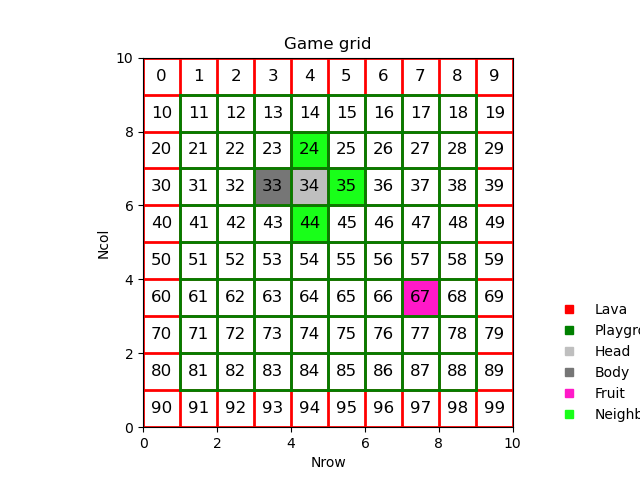

In [98]:
grid_img = np.ones([snake.Nrow, snake.Ncol,3], dtype=np.uint8)*255

# Converting to grid coordinates
# Snake
snake_grid_coor = np.array(snklib.pos_to_coords(snake.snake_active_positions,
                                                 Ncol=snake.Ncol)).T.reshape(
                                                    -1,snake.snake_active_positions.shape[0])
# Fruit
fruit_grid_coor = np.array(snklib.pos_to_coords(snake.fruit_position, snake.Ncol))

# Neighbors
neighbors_grid_coor = np.array(snklib.pos_to_coords(snake.get_neighbors_pos(),
                                                 Ncol=snake.Ncol)).T.reshape(
                                                    -1,snake.snake_active_positions.shape[0])

# Coloring the snake
for ind, sc in enumerate(snake_grid_coor):
    if ind == 0:
        grid_img[sc[0],sc[1], :] = 191 
    else:
        grid_img[sc[0],sc[1], :] = 118 
        
#Coloring fruit 
grid_img[fruit_grid_coor[0], fruit_grid_coor[1], 1] = 25
grid_img[fruit_grid_coor[0], fruit_grid_coor[1], 2] = 200
    
#Coloring the neighbors
for ind, sc in enumerate(neighbors_grid_coor):
    grid_img[sc[0],sc[1], 0] = 25
    grid_img[sc[0],sc[1], 2] = 25



    
plt.figure()
plt.imshow(grid_img,
            origin="upper", extent=[0, snake.Nrow, 0, snake.Ncol])
for l in range(snake.Nrow):
    for c in range(snake.Ncol):
        z = snake.all_positions.reshape(snake.Nrow,snake.Ncol)[l, c]
        xc = snake.Nrow-1 - l
        yc = c        
        plt.text(yc + 0.5, xc + 0.5, str(z), va="center", ha="center", fontsize=12)
        
for g in range(snake.Nrow+1):
    plt.plot(np.linspace(0, snake.Nrow, num=snake.Nrow+1), np.ones(snake.Nrow + 1) * g, "r-", linewidth=2)
    plt.plot(np.ones(snake.Nrow + 1) * g, np.linspace(0, snake.Nrow, num=snake.Nrow+1), "r-", linewidth=2)
    
for g in range(1, snake.Nrow):
    plt.plot(np.linspace(1, snake.Nrow-1, num=snake.Nrow), np.ones(snake.Nrow) * g, "g-", linewidth=2)
    plt.plot(np.ones(snake.Nrow) * g, np.linspace(1, snake.Nrow-1, num=snake.Nrow), "g-", linewidth=2)
        
entries = {"Lava": "red", "Playground": "green",
           "Head":"#BFBFBF",
           "Body":"#767676",
           "Fruit": "#FF19C8",
           "Neighbors":"#19FF19"}
f = lambda m,c: ax.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", val) for key, val in entries.items()]
labels = [key for key, val in entries.items()]
plt.legend(handles, labels, loc=(1.1,0), framealpha=1, frameon=False)

plt.title("Game grid")
plt.xlabel("Nrow")
plt.ylabel("Ncol")
plt.show()

## Question 1
What commands must be given for the snake to eat the first fruit?


In [89]:
# Your answer

## Automatic playing

At first, you are asked to build an agent that will play automatically. It will have to make decisions according to the snake's sensor values. These decisions are to choose the best direction to take.

In [103]:
def improved_agent(sensors):
    """
    A more advanced agent that considers multiple factors.
    """
    turn_neighbors = sensors[:3]
    fcos, fsin = sensors[3:]
    direction_ids = np.array([1, 0, -1])
    head_pos = get_head_pos()
    fruit_pos = get_fruit_pos()
    obstacles_pos = get_obstacles_pos()
    directions_to_fruit = get_directions_to_fruit(head_pos, fruit_pos)
    
    # Check if fruit is within reach
    for direction in np.arange(3):
        if turn_neighbors[direction] == 1 and directions_to_fruit[direction]:
            return direction_ids[direction]
    
    # Move towards the fruit
    if 0.0 in turn_neighbors:
        prefered_directions = np.zeros(3)
        for i, direction in enumerate(directions_to_fruit):
            if direction == 1:
                prefered_directions[i] = 1
        p = prefered_directions * (turn_neighbors >= 0.0)
        if np.sum(p) > 0:
            my_choice = np.where(p == p.max())[0][0]
            return direction_ids[my_choice]
        
    # Avoid obstacles
    for direction in np.arange(3):
        if turn_neighbors[direction] == 1 and not directions_to_fruit[direction]:
            # Check if obstacle is in the way
            obstacle_pos = get_obstacle_pos_in_direction(head_pos, direction_ids[direction])
            if obstacle_pos in obstacles_pos:
                # Try to move in another direction
                available_directions = get_available_directions(head_pos, obstacles_pos)
                if len(available_directions) > 0:
                    my_choice = np.random.choice(available_directions)
                    return direction_ids[my_choice]
    
    # Randomly move in available directions
    available_directions = get_available_directions(head_pos, obstacles_pos)
    if len(available_directions) > 0:
        my_choice = np.random.choice(available_directions)
        return direction_ids[my_choice]
    
    # No available directions, suicide
    return np.random.randint(3)



In [99]:
def my_agent(sensors):
    """
    A simple agent demo.
    """
    turn_neighbors = sensors[:3]
    fcos, fsin = sensors[3:]
    direction_ids = np.array([1, 0, -1])
    # FRUIT IS NEAR ?
    for direction in np.arange(3):
        if turn_neighbors[direction] == 1:
            return direction_ids[direction]
    # OK, NO, THEN GET CLOSER TO IT ?
    if 0.0 in turn_neighbors:
        prefered_directions = np.zeros(3)
        if fcos > 0.0:
            prefered_directions[:] += 0, 3, 0
        elif fcos < 0.0:
            prefered_directions[:] += 1, 0, 1
        if fsin < 0.0:
            prefered_directions[:] += 0, 1, 1
        elif fsin > 0.0:
            prefered_directions[:] += 1, 1, 0
        p = prefered_directions * (turn_neighbors >= 0.0)
        my_choice = np.where(p == p.max())[0][0]
        return direction_ids[my_choice]
    else:
        # OK LET'S SUICIDE
        return np.random.randint(3)


snake = FastSnake(Nrow=10, Ncol=10)
my_choice = my_agent(snake.sensors())
my_choice

-1

## Automatic play with graphic output


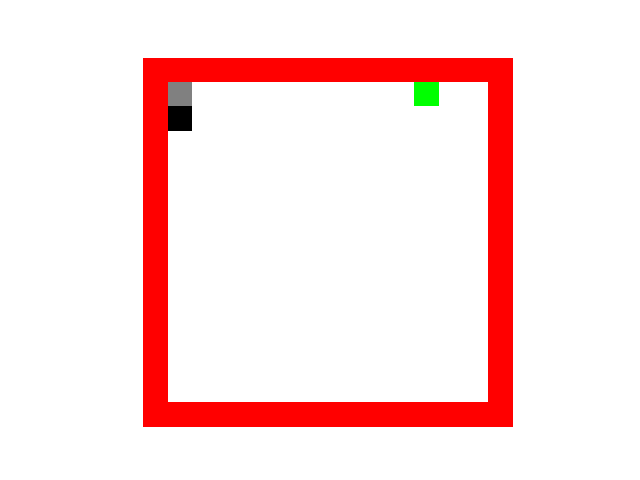

In [104]:
snake5 = FastSnake(Nrow=15, Ncol=15)


def updatefig(*args):
    sensors = snake5.sensors()
    my_choice = my_agent(sensors)
    snake5.turn(my_choice)
    im2.set_array(snake5.grid)
    if snake5.status != 0:
        snake5.reset()
    return (im2,)


fig2, ax2 = plt.subplots()
ax2.axis("off")
im2 = plt.imshow(snake5.grid, interpolation="nearest", animated=True)
anim = animation.FuncAnimation(fig2, updatefig, frames=40, interval=50, blit=True)
plt.show()  # UNCOMMENT TO PLAY
# plt.close()  # COMMENT TO PLAY
# anim  # COMMENT TO PLAY

In [105]:
anim.pause()
plt.close(fig2)

## Benchmark

In [ ]:
Nagent_ids = 200
max_turns = 1000
snake3 = FastSnake(Nrow=10, Ncol=10)
scores = np.zeros(Nagent_ids)
turns = np.zeros(Nagent_ids)
# for agent_id in tqdm.trange(Nagent_ids):
for agent_id in range(Nagent_ids):
    snake3.reset()
    turn = 0
    while snake3.status == 0:
        sensors = snake3.sensors()
        my_choice = my_agent(sensors)
        snake3.turn(my_choice)
        turn += 1
        if turn >= max_turns:
            break
    scores[agent_id] = snake3.score
    turns[agent_id] = turn

In [ ]:
data = pd.DataFrame({"score": scores, "turns": turns})
data.describe().loc[["mean", "std", "max", "min", "count"]].T

## Genetic Neural Network agent 

In [ ]:
# NEURAL FUNCTIONS
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


def ReLu(x):
    return np.where(x > 0.0, x, 0.0)


def identity(x):
    return x


# ARG MAX
def argMax(x):
    return int(np.where(x == x.max())[0][0])


# GENETIC ALGORITHM SETUP

Npop = 100  # NUMBER OF INDIVIDUALS IN THE POPULATION
Ngen = 2  # NUMBER OF GENERATIONS OF EVOLUTION
Ntries = 2  # NUMBER OF TRIES PER INDIVIDUAL PER GENERATION
Net_struct = 5, 3  # NETWORK STRUCTURE
keep_ratio = 0.1  # # GENETIC ALGORITHM KEEP RATIO
mutation_ratio = 0.1  # MUTATION RATIO
mutation_sigma = 0.1  # MUTATION GAUSSIAN SIGMA
max_turns = 1000  # MAX PLAY TURNS PER TRIAL
neural_functions = [identity]  # NEURAL FUNCTION VECTOR


# PRE-PROCESSING
keep_individuals = int(keep_ratio * Npop)
Nw = 0
for i in range(len(Net_struct) - 1):
    nin = Net_struct[i]
    nout = Net_struct[i + 1]
    Nw += (nin + 1) * nout
all_weights = np.random.normal(loc=0.0, scale=1.0, size=(Npop, Nw))
agents = []
for agent_id in range(Npop):
    weights = all_weights[agent_id]
    agent = NeuralAgent(
        weights=weights, structure=Net_struct, neural_functions=neural_functions
    )
    agents.append(agent)
agent_functions = [agent.get_caller() for agent in agents]
func = agent_functions[0]
total_generations = 1

In [ ]:
# DATA STORAGE
snake4 = FastSnake(Nrow=12, Ncol=12)
scores = np.zeros(Npop)
turns = np.zeros(Npop)
tries_scores = np.zeros(Ntries)
tries_turns = np.zeros(Ntries)
new_all_weights = np.zeros_like(all_weights)
turn_ids = np.array([-1.0, 0.0, 1.0])
for generation in range(Ngen):
    print(f"Generation: {total_generations}")
    scores[:] = 0.0
    turns[:] = 0.0
    for agent_id in range(Npop):  # tqdm.trange(Npop):
        tries_scores[:] = 0.0
        tries_turns[:] = 0.0
        agent_func = agent_functions[agent_id]
        for trial in range(Ntries):
            snake4.reset()
            Ncol = snake4.Ncol
            Nrow = snake4.Nrow
            snake4.fruit_position = (Nrow - 2) * Ncol + Ncol - 2
            turn = 0
            # weights = all_weights[agent_id]
            while snake4.status == 0:
                sensors = snake4.sensors()
                my_choice = turn_ids[argMax(agent_func(sensors))]
                snake4.turn(my_choice)
                turn += 1
                if turn >= max_turns:
                    break
            tries_scores[trial] = snake4.score
            tries_turns[trial] = turn
        scores[agent_id] = tries_scores.mean()
        turns[agent_id] = tries_turns.mean()
    perf = scores
    order = np.argsort(perf)[::-1]
    new_all_weights[:] = 0.0
    # SELECTION
    new_all_weights[:keep_individuals] = all_weights[order][:keep_individuals]
    # HYBRIDATION
    keep_range = np.arange(keep_individuals)
    for indiv in range(keep_individuals, Npop):
        parents = np.random.choice(keep_range, 2)
        while parents[1] == parents[0]:
            parents = np.random.choice(keep_range, 2)
        # parents = np.array([0, np.random.randint(1, keep_individuals)])
        pw = np.random.rand()
        # w = new_all_weights[parents[0]] * pw + (1.0 - pw) + new_all_weights[parents[1]]
        cross_over = np.random.randint(1, Nw - 1)
        # new_all_weights[indiv][:cross_over] = new_all_weights[parents[0]][:cross_over]
        # new_all_weights[indiv][cross_over:] = new_all_weights[parents[1]][cross_over:]
        # #= new_all_weights[parents[0]]
        new_all_weights[indiv] = (
            new_all_weights[parents[0]] * pw + (1.0 - pw) + new_all_weights[parents[1]]
        )
        # MUTATION:
        if np.random.rand() <= mutation_ratio:
            mutation_loc = np.random.randint(Nw)
            new_all_weights[indiv] *= np.random.normal(
                loc=1.0, scale=mutation_sigma, size=Nw
            )

        # new_all_weights[indiv] = w
    total_generations += 1
    all_weights[:] = new_all_weights
    print(f"=> best score = {scores.max()}")

    data = pd.DataFrame(
        {"score": scores[order], "turns": turns[order], "perf": perf[order]}
    )  # .sort_values( "perf", ascending=False    )
    print(data.head(5))
print("FINISHED")

In [ ]:
snake5 = FastSnake(Nrow=12, Ncol=12)

# weights = all_weights[0]  # BEST AGENT
best_agent_func = agent_functions[0]
turn_ids = np.array([-1.0, 0.0, 1.0])


def updatefig(*args):
    sensors = snake5.sensors()
    my_choice = turn_ids[argMax(agent_func(sensors))]

    snake5.turn(my_choice)
    im2.set_array(snake5.grid)
    if snake5.status != 0:
        snake5.reset()
    return (im2,)


fig2, ax2 = plt.subplots()
ax2.axis("off")
im2 = plt.imshow(snake5.grid, interpolation="nearest", animated=True)
anim = animation.FuncAnimation(fig2, updatefig, frames=500, interval=50, blit=True)
# plt.show()
plt.close()
anim